### homework1：解决10 monkeys图片分类，并使用resnet50实战

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [13]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize

from pathlib import Path

DATA_DIR = Path("./archive/")


class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, mode, transform=None):
        if mode == "train":
            root = DATA_DIR / "training"
        elif mode == "val":
            root = DATA_DIR / "validation"
        else:
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))
        super().__init__(root, transform)
        self.imgs = self.samples
        self.targets = [s[1] for s in self.samples]


# resnet 要求的，见 https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html
img_h, img_w = 224, 224
transform = Compose([
    Resize((img_h, img_w)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ConvertImageDtype(torch.float),
])

train_ds = MonkeyDataset("train", transform=transform)
val_ds = MonkeyDataset("val", transform=transform)

print("load {} images from training dataset".format(len(train_ds)))
print("load {} images from validation dataset".format(len(val_ds)))

load 1097 images from training dataset
load 272 images from validation dataset


In [14]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

定义模型

In [15]:
from torchvision.models import resnet50


# 定义一个自定义的ResNet50模型类，继承自nn.Module
class ResNet50(nn.Module):
    def __init__(self, num_classes=10, frozen=True):
        super().__init__()

        # 加载预训练的ResNet50模型，并使用IMAGENET1K_V2的预训练权重
        self.model = resnet50(weights="IMAGENET1K_V2")

        # 如果frozen为True，冻结除指定层外的所有层的权重
        if frozen:
            for param in self.model.parameters():
                param.requires_grad = False  # 冻结所有层的权重

        # 解冻指定层的权重
        for name, param in self.model.named_parameters():
            if name == "layer4.2.conv3.weight":
                param.requires_grad = True  # 解冻layer4中的特定卷积层的权重

        # 打印ResNet50最后一层的输入和输出通道数
        # print(self.model.fc.in_features)  # 打印全连接层的输入通道数
        # print(self.model.fc.out_features)  # 打印全连接层的输出通道数（默认是1000类）

        # 替换ResNet50的最后一层全连接层，改为自定义的分类层
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # 将输出类别数改为num_classes

    # 定义前向传播函数
    def forward(self, x):
        return self.model(x)


# 遍历模型的每一层，打印每一层的名称和参数数量
for idx, (key, value) in enumerate(ResNet50().named_parameters()):
    print(f"{key:^40} parameters num: {np.prod(value.shape)}")

           model.conv1.weight            parameters num: 9408
            model.bn1.weight             parameters num: 64
             model.bn1.bias              parameters num: 64
      model.layer1.0.conv1.weight        parameters num: 4096
       model.layer1.0.bn1.weight         parameters num: 64
        model.layer1.0.bn1.bias          parameters num: 64
      model.layer1.0.conv2.weight        parameters num: 36864
       model.layer1.0.bn2.weight         parameters num: 64
        model.layer1.0.bn2.bias          parameters num: 64
      model.layer1.0.conv3.weight        parameters num: 16384
       model.layer1.0.bn3.weight         parameters num: 256
        model.layer1.0.bn3.bias          parameters num: 256
   model.layer1.0.downsample.0.weight    parameters num: 16384
   model.layer1.0.downsample.1.weight    parameters num: 256
    model.layer1.0.downsample.1.bias     parameters num: 256
      model.layer1.1.conv1.weight        parameters num: 16384
       model.layer1.

训练

In [16]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [17]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [18]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [19]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [20]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [21]:
epoch = 20

model = ResNet50(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 sgd
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback("runs/monkeys-resnet50")
# tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/monkeys-resnet50", save_step=len(train_loader),
                                             save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [22]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
)

  0%|          | 0/700 [00:00<?, ?it/s]

Early stop at epoch 10 / global_step 350


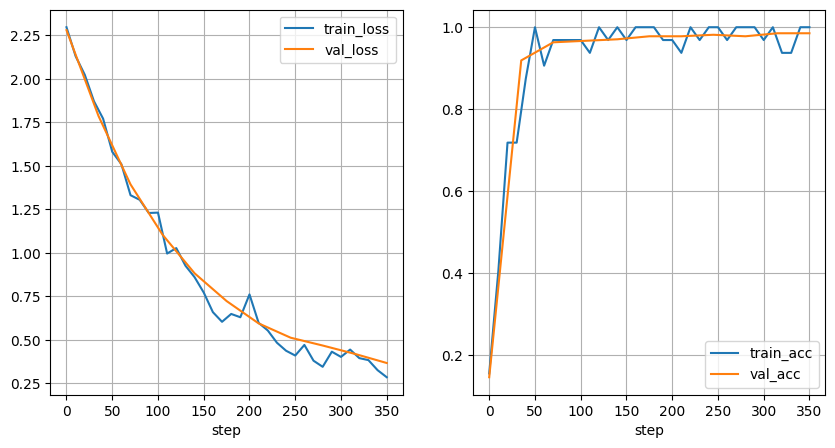

In [23]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [24]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/monkeys-resnet50/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3662
accuracy: 0.9853


### homework2：解决cifar10，提交自己的submission.csv，查看kaggle排名

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [2]:
from pathlib import Path

# 定义数据目录路径
DATA_DIR = Path("G:/my_first_github/data/cifar-10")

# 定义训练集标签文件路径
train_lables_file = DATA_DIR / "trainLabels.csv"
# 定义测试集模板csv文件路径
test_csv_file = DATA_DIR / "sampleSubmission.csv"
# 定义训练集图片文件夹路径
train_folder = DATA_DIR / "train"
# 定义测试集图片文件夹路径
test_folder = DATA_DIR / "test"

# 定义所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):
    """
    解析csv文件，将其转换为(filename(path), label)格式

    参数:
    filepath (str): csv文件路径
    folder (Path): 图片所在文件夹路径

    返回:
    list: 包含元组(filename(path), label)的列表
    """
    results = []
    # 读取csv文件的所有行
    with open(filepath, 'r') as f:
        # 跳过第一行（标题行），从第二行开始读取
        lines = f.readlines()[1:]

    # 遍历每一行
    for line in lines:
        # 去除行尾的换行符，并按逗号分隔图片ID和标签
        image_id, label_str = line.strip('\n').split(',')
        # 构建图片的完整路径
        image_full_path = folder / f"{image_id}.png"
        # 将图片路径和标签添加到结果列表中
        results.append((image_full_path, label_str))

    return results


# 解析训练集标签文件
train_labels_info = parse_csv_file(train_lables_file, train_folder)
# 解析测试集模板csv文件
test_csv_info = parse_csv_file(test_csv_file, test_folder)

# 打印解析结果的前5项
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])

# 打印训练集和测试集的数量
print(len(train_labels_info), len(test_csv_info))

[(WindowsPath('G:/my_first_github/data/cifar-10/train/1.png'), 'frog'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/2.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/3.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/4.png'), 'deer'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/5.png'), 'automobile')]
[(WindowsPath('G:/my_first_github/data/cifar-10/test/1.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/2.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/3.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/4.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/5.png'), 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
# 将训练集标签信息转换为DataFrame，并取前45000张图片作为训练集
train_df = pd.DataFrame(train_labels_info[0:45000])

# 将训练集标签信息的后5000张图片作为验证集
valid_df = pd.DataFrame(train_labels_info[45000:])

# 将测试集标签信息转换为DataFrame
test_df = pd.DataFrame(test_csv_info)

# 为DataFrame设置列名，'filepath'表示图片路径，'class'表示图片类别
train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

# 打印训练集、验证集和测试集的前几行数据
print(train_df.head())  # 打印训练集的前5行
print(valid_df.head())  # 打印验证集的前5行
print(test_df.head())  # 打印测试集的前5行

                                       filepath       class
0  G:\my_first_github\data\cifar-10\train\1.png        frog
1  G:\my_first_github\data\cifar-10\train\2.png       truck
2  G:\my_first_github\data\cifar-10\train\3.png       truck
3  G:\my_first_github\data\cifar-10\train\4.png        deer
4  G:\my_first_github\data\cifar-10\train\5.png  automobile
                                           filepath       class
0  G:\my_first_github\data\cifar-10\train\45001.png       horse
1  G:\my_first_github\data\cifar-10\train\45002.png  automobile
2  G:\my_first_github\data\cifar-10\train\45003.png        deer
3  G:\my_first_github\data\cifar-10\train\45004.png  automobile
4  G:\my_first_github\data\cifar-10\train\45005.png    airplane
                                      filepath class
0  G:\my_first_github\data\cifar-10\test\1.png   cat
1  G:\my_first_github\data\cifar-10\test\2.png   cat
2  G:\my_first_github\data\cifar-10\test\3.png   cat
3  G:\my_first_github\data\cifar-10\test\4.p

In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# 定义CIFAR-10数据集类，继承自PyTorch的Dataset类
class Cifar10Dataset(Dataset):
    # 类属性：映射模式（train, eval, test）到对应的DataFrame
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }

    # 类别名称到索引的映射
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    # 索引到类别名称的映射（主要用于测试集）
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}

    def __init__(self, mode, transform=None):
        """
        初始化函数

        参数:
        mode (str): 数据集模式，可以是 "train"、"eval" 或 "test"
        transform (callable, optional): 数据增强和预处理函数
        """
        # 根据模式获取对应的DataFrame
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # 设置数据增强和预处理函数
        self.transform = transform

    def __getitem__(self, index):
        """
        获取单个样本

        参数:
        index (int): 样本索引

        返回:
        img (Tensor): 图像数据
        label (int): 标签索引
        """
        # 从DataFrame中获取图片路径和标签
        img_path, label = self.df.iloc[index]
        # 打开图片并转换为RGB格式
        img = Image.open(img_path).convert('RGB')
        # 应用数据增强和预处理
        if self.transform:
            img = self.transform(img)
        # 将标签转换为索引
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        """
        返回数据集的大小

        返回:
        int: 数据集中的样本数量
        """
        return self.df.shape[0]


# 定义图像大小和标准化参数
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# 训练集的数据增强和预处理
transforms_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 缩放图像
    transforms.RandomRotation(40),  # 随机旋转图像
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.ToTensor(),  # 将图像转换为Tensor，并归一化到[0, 1]
    # transforms.Normalize(mean, std)  # 标准化（可选）
])

# 验证集和测试集的数据预处理
transforms_eval = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 缩放图像
    transforms.ToTensor(),  # 将图像转换为Tensor，并归一化到[0, 1]
    # transforms.Normalize(mean, std)  # 标准化（可选）
])

# 创建训练集和验证集的Dataset对象
train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

定义模型

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),  # 批标准化，在通道数做的归一化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),  #输出尺寸（128，32，32）
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（128，16，16）
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),  #输出尺寸（256，16，16）
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（256，8，8）
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),  #输出尺寸（512，8，8）
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2),  #输出尺寸（512，4，4）
            nn.Flatten(),  #展平
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )  #Sequential自动连接各层，把各层的输出作为下一层的输入

    def forward(self, x):
        return self.model(x)


for key, value in CNN(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 3456
              model.0.bias              paramerters num: 128
             model.2.weight             paramerters num: 128
              model.2.bias              paramerters num: 128
             model.3.weight             paramerters num: 147456
              model.3.bias              paramerters num: 128
             model.5.weight             paramerters num: 128
              model.5.bias              paramerters num: 128
             model.7.weight             paramerters num: 294912
              model.7.bias              paramerters num: 256
             model.9.weight             paramerters num: 256
              model.9.bias              paramerters num: 256
            model.10.weight             paramerters num: 589824
             model.10.bias              paramerters num: 256
            model.12.weight             paramerters num: 256
             model.12.bias              paramerters num: 256
            mo

训练

In [7]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [8]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [9]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [10]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [11]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)  #最大值的索引

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())  # 计算准确率
                loss = loss.cpu().item()  # 计算损失
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step  # 记录每一步的损失和准确率
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [12]:
epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/cifar-10")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [13]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

  0%|          | 0/14080 [00:00<?, ?it/s]

Early stop at epoch 18 / global_step 12672


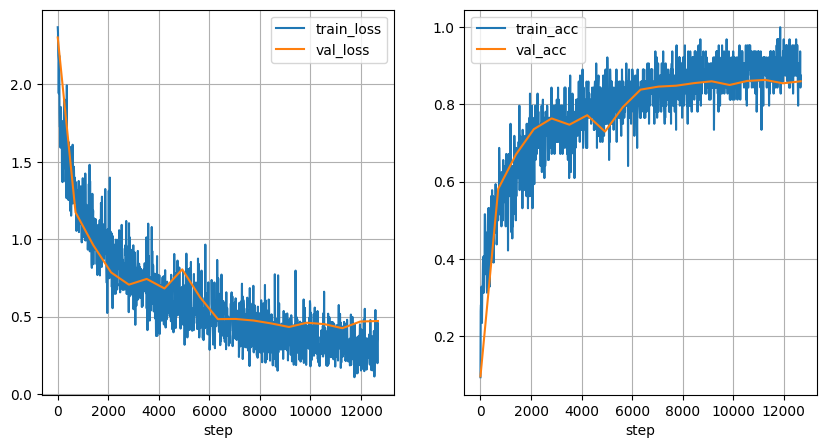

In [14]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [15]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4254
accuracy: 0.8636


推理

In [42]:
# 创建测试集的Dataset对象
test_ds = Cifar10Dataset("test", transform=transforms_eval)

# 创建测试集的DataLoader对象
# batch_size: 每个批次的样本数量
# shuffle=False: 测试集不需要打乱顺序
# drop_last=False: 不丢弃最后一个不完整的批次
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# 初始化一个列表，用于收集所有预测结果
preds_collect = []

# 将模型设置为评估模式
model.eval()

# 使用tqdm包装DataLoader，以便显示进度条
for data, fake_label in tqdm(test_dl):
    # 将数据移动到指定的设备（如GPU）
    data = data.to(device=device)

    # 使用模型进行预测，得到logits（未归一化的预测值）
    logits = model(data)

    # 将logits转换为预测类别
    # logits.argmax(axis=-1): 找到每个样本预测概率最大的类别索引
    # .cpu().tolist(): 将结果从GPU移动到CPU，并转换为Python列表
    # test_ds.idx_to_label: 将类别索引映射回类别名称
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]

    # 将当前批次的预测结果添加到收集器中
    preds_collect.extend(preds)

  0%|          | 0/4688 [00:00<?, ?it/s]

In [43]:
test_df.head()

,filepath,class
0,G:\my_first_github\data\cifar-10\test\1.png,cat
1,G:\my_first_github\data\cifar-10\test\2.png,cat
2,G:\my_first_github\data\cifar-10\test\3.png,cat
3,G:\my_first_github\data\cifar-10\test\4.png,cat
4,G:\my_first_github\data\cifar-10\test\5.png,cat


In [44]:
test_df1 = pd.DataFrame(list(range(1, 3 * 10 ** 5 + 1)), columns=["id"])
test_df1

,id
0,1
1,2
2,3
3,4
4,5
...,...
299995,299996
299996,299997
299997,299998
299998,299999


In [45]:
test_df1["label"] = preds_collect  # 增加预测类别列,比赛要求这一列是label
test_df1.head()

,id,label
0,1,bird
1,2,airplane
2,3,automobile
3,4,ship
4,5,airplane


In [46]:
# 导出 submission.csv
test_df1.to_csv("submission.csv", index=False)

### homework3：完成VGG网络搭建，理解模型结构

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [2]:
from pathlib import Path

DATA_DIR = Path("G:/my_first_github/data/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"  #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):  #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:]
    for line in lines:  #依次去取每一行
        image_id, label_str = line.strip('\n').split(',')  #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str))  #得到对应图片的路径和分类
    return results


#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(WindowsPath('G:/my_first_github/data/cifar-10/train/1.png'), 'frog'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/2.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/3.png'), 'truck'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/4.png'), 'deer'),
 (WindowsPath('G:/my_first_github/data/cifar-10/train/5.png'), 'automobile')]
[(WindowsPath('G:/my_first_github/data/cifar-10/test/1.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/2.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/3.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/4.png'), 'cat'),
 (WindowsPath('G:/my_first_github/data/cifar-10/test/5.png'), 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                       filepath       class
0  G:\my_first_github\data\cifar-10\train\1.png        frog
1  G:\my_first_github\data\cifar-10\train\2.png       truck
2  G:\my_first_github\data\cifar-10\train\3.png       truck
3  G:\my_first_github\data\cifar-10\train\4.png        deer
4  G:\my_first_github\data\cifar-10\train\5.png  automobile
                                           filepath       class
0  G:\my_first_github\data\cifar-10\train\45001.png       horse
1  G:\my_first_github\data\cifar-10\train\45002.png  automobile
2  G:\my_first_github\data\cifar-10\train\45003.png        deer
3  G:\my_first_github\data\cifar-10\train\45004.png  automobile
4  G:\my_first_github\data\cifar-10\train\45005.png    airplane
                                      filepath class
0  G:\my_first_github\data\cifar-10\test\1.png   cat
1  G:\my_first_github\data\cifar-10\test\2.png   cat
2  G:\my_first_github\data\cifar-10\test\3.png   cat
3  G:\my_first_github\data\cifar-10\test\4.p

In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}

    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))

        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0]


IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # random rotation 40
    transforms.RandomRotation(40),
    # horizaontal flip
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transforms_eval = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

定义模型

In [6]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            # 输入[3, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),  # 32*32*32
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32*32*32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32*16*16
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32*16*16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32*8*8
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32*8*8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 32*4*4
            nn.Flatten(),
            nn.Linear(512, num_classes),
        )
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)


for key, value in VGG(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 864
              model.0.bias              paramerters num: 32
             model.2.weight             paramerters num: 9216
              model.2.bias              paramerters num: 32
             model.5.weight             paramerters num: 9216
              model.5.bias              paramerters num: 32
             model.7.weight             paramerters num: 9216
              model.7.bias              paramerters num: 32
            model.10.weight             paramerters num: 9216
             model.10.bias              paramerters num: 32
            model.12.weight             paramerters num: 9216
             model.12.bias              paramerters num: 32
            model.16.weight             paramerters num: 5120
             model.16.bias              paramerters num: 10


In [7]:
#模型总参数量
total_params = sum(p.numel() for p in VGG(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 52266


训练

In [8]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [9]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [10]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [11]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [12]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [13]:
epoch = 10

model = VGG(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
#可以修改adam里边的weight_decay参数，来控制L2正则化的程度,beta1和beta2是指数衰减率
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/vgg")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/vgg", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [ ]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

  0%|          | 0/7040 [00:00<?, ?it/s]

In [ ]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=100)  #横坐标是 steps

评估

In [ ]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/vgg/best.ckpt", map_location="cpu", weigths_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

### homework4：完成ResNet网络搭建，理解模型结构

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

数据准备

In [ ]:
from pathlib import Path

DATA_DIR = Path("G:/my_first_github/data/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"  #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):  #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:]
    for line in lines:  #依次去取每一行
        image_id, label_str = line.strip('\n').split(',')  #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str))  #得到对应图片的路径和分类
    return results


#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

In [ ]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}

    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))

        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0]


IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # random rotation 40
    transforms.RandomRotation(40),
    # horizaontal flip
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transforms_eval = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

定义模型

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Residual(nn.Module):
    """浅层的残差块，无 bottleneck（性能限制）"""

    def __init__(self, input_channels, output_channels, use_1x1conv=False, stride=1):
        """
        残差块

        参数:
        - input_channels (int): 输入特征图的通道数。
        - output_channels (int): 输出特征图的通道数。
        - use_1x1conv (bool): 是否使用 1x1 卷积。如果为 True，则使用 1x1 卷积调整通道数和进行降采样。
        - stride (int): 卷积的步长。默认为 1，当需要降采样时设置为 2。
        """
        super().__init__()

        # 第一个卷积层：3x3 卷积，用于提取特征
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=output_channels,
            kernel_size=3,
            stride=stride,  # 步长，用于降采样
            padding=1,  # 填充，保持特征图尺寸不变
        )

        # 第二个卷积层：3x3 卷积，用于进一步提取特征
        self.conv2 = nn.Conv2d(
            in_channels=output_channels,
            out_channels=output_channels,
            kernel_size=3,
            stride=1,  # 步长为 1
            padding=1,  # 填充，保持特征图尺寸不变
        )

        # 如果需要使用 1x1 卷积（用于调整通道数或降采样）
        if use_1x1conv:
            # skip connection 的 1x1 卷积，用于改变通道数和降采样
            self.conv_sc = nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=1,
                stride=stride,  # 步长，用于降采样
            )
        else:
            self.conv_sc = None  # 如果不使用 1x1 卷积，设为 None

        # Batch Normalization 层，用于加速训练和稳定模型
        self.bn1 = nn.BatchNorm2d(output_channels, eps=1e-5, momentum=0.9)
        self.bn2 = nn.BatchNorm2d(output_channels, eps=1e-5, momentum=0.9)

    def forward(self, inputs):
        """
        前向传播

        参数:
        - inputs (Tensor): 输入特征图，形状为 [batch_size, input_channels, height, width]

        返回:
        - output (Tensor): 输出特征图，形状为 [batch_size, output_channels, height, width]
        """
        # 第一个卷积 -> BatchNorm -> ReLU
        flow = F.relu(self.bn1(self.conv1(inputs)))

        # 第二个卷积 -> BatchNorm
        flow = self.bn2(self.conv2(flow))

        # 如果使用了 1x1 卷积，则对输入进行 1x1 卷积调整通道数和降采样
        if self.conv_sc:
            inputs = self.conv_sc(inputs)

        # 残差连接：将卷积后的结果与输入相加，然后通过 ReLU 激活函数
        return F.relu(flow + inputs)

In [ ]:
import torch.nn as nn


class ResidualBlock(nn.Module):
    """若干个 Residual 模块堆叠在一起，通常在第一个模块给 skip connection 使用 1x1conv with stride=2"""

    def __init__(self, input_channels, output_channels, num, is_first=False):
        """
        初始化函数

        参数:
        - input_channels (int): 输入特征图的通道数。
        - output_channels (int): 输出特征图的通道数。
        - num (int): 堆叠的 Residual 模块数量。
        - is_first (bool): 是否是第一个 ResidualBlock。如果是第一个模块，则 stride=1，否则 stride=2。
        """
        super().__init__()

        # 用于存放 Residual 模块的 Sequential 容器
        self.model = nn.Sequential()

        # 第一个 Residual 模块
        self.model.append(Residual(
            input_channels=input_channels,
            output_channels=output_channels,
            use_1x1conv=not is_first,  # 如果不是第一个模块，则使用 1x1 卷积
            stride=1 if is_first else 2  # 如果是第一个模块，stride=1，否则 stride=2
        ))

        # 堆叠剩余的 Residual 模块
        for _ in range(1, num):
            self.model.append(Residual(
                input_channels=output_channels,
                output_channels=output_channels,
                use_1x1conv=False,  # 后续模块不使用 1x1 卷积
                stride=1  # 后续模块的 stride 固定为 1
            ))

    def forward(self, inputs):
        """
        前向传播

        参数:
        - inputs (Tensor): 输入特征图，形状为 [batch_size, input_channels, height, width]

        返回:
        - output (Tensor): 输出特征图，形状为 [batch_size, output_channels, height, width]
        """
        return self.model(inputs)

In [ ]:
import torch.nn as nn
import torch.nn.init as init


class ResNetForCifar10(nn.Module):
    def __init__(self, n=3, num_classes=10):
        """
        初始化函数

        参数:
        - n (int): 控制每个 ResidualBlock 中 Residual 模块的数量。默认值为 3，表示每个 ResidualBlock 包含 2*n 个 Residual 模块。
        - num_classes (int): 分类任务的类别数。CIFAR-10 数据集默认类别数为 10。
        """
        super().__init__()

        # 定义模型的主体结构
        self.model = nn.Sequential(
            # 第一层卷积：3x3 卷积，输入通道为 3（RGB 图像），输出通道为 16
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,  # 添加 padding 以保持特征图尺寸不变
            ),
            nn.BatchNorm2d(16, momentum=0.9, eps=1e-5),  # Batch Normalization
            nn.ReLU(),  # ReLU 激活函数

            # 第一个 ResidualBlock：输入通道为 16，输出通道为 16，包含 2*n 个 Residual 模块
            ResidualBlock(input_channels=16, output_channels=16, num=2 * n, is_first=True),  # conv2_x

            # 第二个 ResidualBlock：输入通道为 16，输出通道为 32，包含 2*n 个 Residual 模块
            ResidualBlock(input_channels=16, output_channels=32, num=2 * n),  # conv3_x

            # 第三个 ResidualBlock：输入通道为 32，输出通道为 64，包含 2*n 个 Residual 模块
            ResidualBlock(input_channels=32, output_channels=64, num=2 * n),  # conv4_x

            # 全局平均池化层：将特征图的宽度和高度压缩为 1x1
            nn.AdaptiveAvgPool2d((1, 1)),

            # 展平层：将多维特征图展平为一维向量
            nn.Flatten(),

            # 全连接层：输入特征数为 64，输出特征数为类别数
            nn.Linear(in_features=64, out_features=num_classes),
        )

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """
        使用 Kaiming 均匀分布初始化卷积层和全连接层的权重，并将偏置初始化为 0
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                init.kaiming_uniform_(m.weight)  # Kaiming 初始化
                init.zeros_(m.bias)  # 偏置初始化为 0

    def forward(self, inputs):
        """
        前向传播

        参数:
        - inputs (Tensor): 输入图像，形状为 [batch_size, 3, height, width]

        返回:
        - output (Tensor): 输出分类结果，形状为 [batch_size, num_classes]
        """
        return self.model(inputs)


for key, value in ResNetForCifar10(num_classes=len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

In [ ]:
#模型总参数量
total_params = sum(p.numel() for p in ResNetForCifar10(num_classes=len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

In [ ]:
#随机一个张量，喂给上面的model
x = torch.randn(1, 3, 32, 32)
model = ResNetForCifar10(num_classes=len(class_names))
model(x).shape

训练

In [ ]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [ ]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [ ]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [ ]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [ ]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)  #最大值的索引

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())  # 计算准确率
                loss = loss.cpu().item()  # 计算损失
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step  # 记录每一步的损失和准确率
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [ ]:
epoch = 20

model = ResNetForCifar10(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()


# 2. 定义优化器 采用 Rmsprop
# Optimizers specified in the torch.optim package
# >>> # Assuming optimizer uses lr = 0.05 for all groups
# >>> # lr = 0.05     if epoch < 30
# >>> # lr = 0.005    if 30 <= epoch < 80
# >>> # lr = 0.0005   if epoch >= 80
# >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

class OptimizerWithScheduler:
    def __init__(self, parameters, lr, momentum, weight_decay):
        self.optimizer = torch.optim.SGD(parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)  # 优化器
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[32_000, 48_000],
                                                              gamma=0.1)  # 学习率衰减

    def step(self):
        self.optimizer.step()
        self.scheduler.step()

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def zero_grad(self):
        self.optimizer.zero_grad()


optimizer = OptimizerWithScheduler(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")

exp_name = "resnet34"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/{exp_name}", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [ ]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

In [ ]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

In [ ]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu", weigth_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

### homework5：完成InceptionNet网络搭建，理解模型结构

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

数据准备

In [ ]:
from pathlib import Path

DATA_DIR = Path("G:/my_first_github/data/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"  #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):  #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:]
    for line in lines:  #依次去取每一行
        image_id, label_str = line.strip('\n').split(',')  #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str))  #得到对应图片的路径和分类
    return results


#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

In [ ]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}

    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))

        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0]


IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # random rotation 40
    transforms.RandomRotation(40),
    # horizaontal flip
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transforms_eval = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

定义模型

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class InceptionBlock(nn.Module):
    """
    Inception 模块，包含 1x1 卷积、3x3 卷积、5x5 卷积和最大池化路径。
    所有路径的输出在通道维度上拼接。

    参数:
    - input_channels (int): 输入特征图的通道数。
    - output_channel_for_each_path (list[int]): 每条路径的输出通道数，顺序为 [1x1 卷积, 3x3 卷积, 5x5 卷积, 最大池化]。
    """

    def __init__(self, input_channels: int, output_channel_for_each_path: list[int]):
        super(InceptionBlock, self).__init__()

        # 1x1 卷积路径
        self.conv1_1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=output_channel_for_each_path[0],
            kernel_size=1,
            padding="same"  # 保持特征图尺寸不变
        )

        # 3x3 卷积路径
        self.conv3_3 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=output_channel_for_each_path[1],
            kernel_size=3,
            padding="same"  # 保持特征图尺寸不变
        )

        # 5x5 卷积路径
        self.conv5_5 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=output_channel_for_each_path[2],
            kernel_size=5,
            padding="same"  # 保持特征图尺寸不变
        )

        # 最大池化路径
        self.max_pooling = nn.MaxPool2d(
            kernel_size=2,
            stride=2,  # 步长为 2，特征图尺寸减半
        )

    def forward(self, x):
        """
        前向传播

        参数:
        - x (Tensor): 输入特征图，形状为 [batch_size, input_channels, height, width]

        返回:
        - concat_output (Tensor): 拼接后的输出特征图，形状为 [batch_size, total_output_channels, height, width]
        """
        # 1x1 卷积路径
        conv1_1 = F.relu(self.conv1_1(x))

        # 3x3 卷积路径
        conv3_3 = F.relu(self.conv3_3(x))

        # 5x5 卷积路径
        conv5_5 = F.relu(self.conv5_5(x))

        # 最大池化路径
        max_pooling = self.max_pooling(x)  # 最大池化，特征图尺寸减半

        # 计算填充量，使池化后的特征图尺寸与输入一致
        max_pooling_shape = max_pooling.shape[1:]  # 池化后的形状 [channels, height, width]
        input_shape = x.shape[1:]  # 输入的形状 [channels, height, width]
        width_padding = (input_shape[-2] - max_pooling_shape[-2]) // 2  # 宽度方向填充量
        height_padding = (input_shape[-1] - max_pooling_shape[-1]) // 2  # 高度方向填充量

        # 对池化结果进行填充
        padded_pooling = F.pad(
            max_pooling,
            [width_padding, width_padding, height_padding, height_padding]  # [left, right, top, bottom]
        )

        # 在通道维度上拼接所有路径的输出
        concat_output = torch.cat(
            [conv1_1, conv3_3, conv5_5, padded_pooling],
            dim=1  # 在通道维度上拼接
        )

        return concat_output

In [ ]:
class InceptionNet(nn.Module):
    """
    InceptionNet 模型，包含多个 InceptionBlock 模块，用于图像分类任务。
    """

    def __init__(self, num_classes=10):
        """
        初始化函数

        参数:
        - num_classes (int): 分类任务的类别数。CIFAR-10 数据集默认类别数为 10。
        """
        super(InceptionNet, self).__init__()

        # 定义模型的主体结构
        self.model = nn.Sequential(
            # 第一层卷积：3x3 卷积，输入通道为 3（RGB 图像），输出通道为 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),  # ReLU 激活函数

            # 最大池化层：2x2 池化，步长为 2，特征图尺寸减半
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出形状：[32, 16, 16]

            # 第一个 InceptionBlock：输入通道为 32，输出通道为 [16, 16, 16]
            InceptionBlock(input_channels=32, output_channel_for_each_path=[16, 16, 16]),  # 输出形状：[80, 16, 16]

            # 第二个 InceptionBlock：输入通道为 80，输出通道为 [16, 16, 16]
            InceptionBlock(input_channels=80, output_channel_for_each_path=[16, 16, 16]),  # 输出形状：[128, 16, 16]

            # 最大池化层：2x2 池化，步长为 2，特征图尺寸减半
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出形状：[128, 8, 8]

            # 第三个 InceptionBlock：输入通道为 128，输出通道为 [16, 16, 16]
            InceptionBlock(input_channels=128, output_channel_for_each_path=[16, 16, 16]),  # 输出形状：[176, 8, 8]

            # 第四个 InceptionBlock：输入通道为 176，输出通道为 [16, 16, 16]
            InceptionBlock(input_channels=176, output_channel_for_each_path=[16, 16, 16]),  # 输出形状：[224, 8, 8]

            # 最大池化层：2x2 池化，步长为 2，特征图尺寸减半
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出形状：[224, 4, 4]

            # 展平层：将多维特征图展平为一维向量
            nn.Flatten(),

            # 全连接层：输入特征数为 224*4*4=3584，输出特征数为类别数
            nn.Linear(3584, num_classes),
        )

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """
        使用 Xavier 均匀分布初始化卷积层和全连接层的权重，并将偏置初始化为 0
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                init.xavier_uniform_(m.weight)  # Xavier 初始化
                init.zeros_(m.bias)  # 偏置初始化为 0

    def forward(self, x):
        """
        前向传播

        参数:
        - x (Tensor): 输入图像，形状为 [batch_size, 3, height, width]

        返回:
        - output (Tensor): 输出分类结果，形状为 [batch_size, num_classes]
        """
        return self.model(x)


for key, value in InceptionNet(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

In [ ]:
#计算总参数量
total_params = sum(p.numel() for p in InceptionNet(len(class_names)).parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")

训练

In [ ]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [ ]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [ ]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [ ]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [ ]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [ ]:
epoch = 20

model = InceptionNet(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 Rmsprop
# Optimizers specified in the torch.optim package
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-07)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")

exp_name = "inception_net"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/{exp_name}", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [ ]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

In [ ]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=100)  #横坐标是 steps

评估

In [ ]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")